# Importar Librerias

In [11]:
from gurobipy import *
import networkx as nx
import matplotlib.pyplot as plt
import openpyxl 
import pandas as pd
import numpy as np

# Importación de Datos

In [144]:
# Datos globales
nref  = 1          # nodo de referencia
vref  = 1.0        # tensión en la subestación (pu)
vbase = 12.66      # Tensión base (kV)
sbase = 1000       # Potencia base (kVA)
tol   = 10e-8      # Tolerancia del error permitido
vmin  = 0.93       # Tensión mínima (pu)
vmax  = 1.05       # Tensión máxima (pu)
delV=vmax-vmin

# Base de impedancia
zbase = 1000*((vbase**2)/sbase)

# Datos de ramas
#         de   para  R(ohm)  X(ohm)
ramos = [
            [1, 2, 0.0922, 0.0470],
            [2, 3, 0.4930, 0.2511],
            [3, 4, 0.3660, 0.1864],
            [4, 5, 0.3811, 0.1941],
            [5, 6, 0.8190, 0.7070],
            [6, 7, 0.1872, 0.6188],
            [7, 8, 0.7114, 0.2351],
            [8, 9, 1.0300, 0.7400],
            [9, 10, 1.0440, 0.7400],
            [10, 11, 0.1966, 0.0650],
            [11, 12, 0.3744, 0.1238],
            [12, 13, 1.4680, 1.1550],
            [13, 14, 0.5416, 0.7129],
            [14, 15, 0.5910, 0.5260],
            [15, 16, 0.7463, 0.5450],
            [16, 17, 1.2890, 1.7210],
            [17, 18, 0.7320, 0.5740],
            [2, 19, 0.1640, 0.1565],
            [19, 20, 1.5042, 1.3554],
            [20, 21, 0.4095, 0.4784],
            [21, 22, 0.7089, 0.9373],
            [3, 23, 0.4512, 0.3083],
            [23, 24, 0.8980, 0.7091],
            [24, 25, 0.8960, 0.7011],
            [6, 26, 0.2030, 0.1034],
            [26, 27, 0.2842, 0.1447],
            [27, 28, 1.0590, 0.9337],
            [28, 29, 0.8042, 0.7006],
            [29, 30, 0.5075, 0.2585],
            [30, 31, 0.9744, 0.9630],
            [31, 32, 0.3105, 0.3619],
            [32, 33, 0.3410, 0.5302],
            [8, 21, 2.0000, 2.0000],
            [9, 15, 2.0000, 2.0000],
            [12, 22, 2.0000, 2.0000],
            [18, 33, 0.5000, 0.5000],
            [25, 29, 0.5000, 0.5000]
]

# Demanda de potencia activa y reactiva en las barras
#            barra Pd(kW) Qd(kW) Qbc(kW)
barras = [
    [1, 0, 0, 0.00],
    [2, 100, 60, 0.00],
    [3, 90, 40, 0.00],
    [4, 120, 80, 0.00],
    [5, 60, 30, 0.00],
    [6, 60, 20, 0.00],
    [7, 200, 100, 0.00],
    [8, 200, 100, 0.00],
    [9, 60, 20, 0.00],
    [10, 60, 20, 0.00],
    [11, 45, 30, 0.00],
    [12, 60, 35, 0.00],
    [13, 60, 35, 0.00],
    [14, 120, 80, 0.00],
    [15, 60, 10, 0.00],
    [16, 60, 20, 0.00],
    [17, 60, 20, 0.00],
    [18, 90, 40, 0.00],
    [19, 90, 40, 0.00],
    [20, 90, 40, 0.00],
    [21, 90, 40, 0.00],
    [22, 90, 40, 0.00],
    [23, 90, 50, 0.00],
    [24, 420, 200, 0.00],
    [25, 420, 200, 0.00],
    [26, 60, 25, 0.00],
    [27, 60, 25, 0.00],
    [28, 60, 20, 0.00],
    [29, 120, 70, 0.00],
    [30, 200, 600, 0.00],
    [31, 150, 70, 0.00],
    [32, 210, 100, 0.00],
    [33, 60, 40, 0.00]
]


# Conjuntos y Parámetros

In [160]:
# Nodos
N = list(range(1,len(barras)+1))

# Arcos
B = [(ramos[i][0],ramos[i][1]) for i in range(len(ramos))]

# =============================
# PARAMETROS
# =============================

r={}
x={}
for i in ramos:
    r[(i[0],i[1])]=i[2]/zbase
    x[(i[0],i[1])]=i[3]/zbase
  
pd={}
qd={}
for i in barras:
    pd[i[0]]=i[1]/sbase
    qd[i[0]]=i[2]/sbase

# Grafo

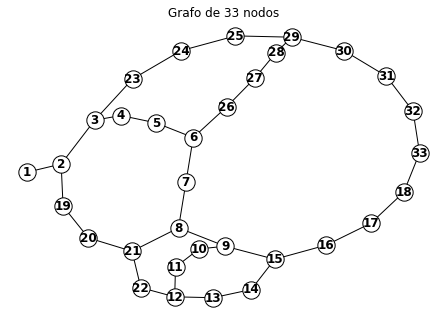

In [182]:
grafo=[]

G = nx.Graph()

G.add_nodes_from(N)

G.add_edges_from(B)
nx.draw(G, with_labels=True, node_color="white", font_weight='bold', edgecolors='black')
plt.title("Grafo de 33 nodos")
plt.show()

# Creación del Modelo y Variables

In [199]:
m=Model('RDS')
m.setParam('MIPGap', tol)

y={}
delta={}
I={}
p={}
q={}
bv={}
for b in B:
    y[b]=m.addVar(vtype=GRB.BINARY, name ="y")
    delta[b]=m.addVar(vtype=GRB.CONTINUOUS, name="delta", lb=-delV, ub=delV)
    I[b]=m.addVar(vtype=GRB.CONTINUOUS, name="I", lb=0)
    p[b]=m.addVar(vtype=GRB.CONTINUOUS, lb= 0, name = "p")
    q[b]=m.addVar(vtype=GRB.CONTINUOUS,  name = "q")
    bv[b]=m.addVar(vtype=GRB.CONTINUOUS, name="bv")

v={}
for n in N:
    v[n]=m.addVar(vtype=GRB.CONTINUOUS, name="v", lb=vmin**2, ub=vmax**2)

Set parameter MIPGap to value 1e-07


# Modelo Matemático 

## Función Objetivo

$$
Min \sum\limits_{ij \in {B}} {{R_{ij}}I_{ij}^{sqr}};
$$


In [200]:
FO = quicksum(r[b]*I[b] for b in B)
m.setObjective(FO,GRB.MINIMIZE)

## Restricciones

$$
\sum\limits_{ki \in {B}} {{P_{ki}}}   - \sum\limits_{ij \in {B}} {\left( {{P_{ij}} + {R_{ij}}I_{ij}^{2}} \right)} + P_{i,t}^S = P_{i,t}^D \forall i \in {N}
$$ 
$$
\sum\limits_{ki \in {B}} {{Q_{ki,t}}}   - \sum\limits_{ij \in {B}} {\left( {{Q_{ij}} + {X_{ij}}I_{ij}^{sqr}} \right)}  + Q_{i}^S= Q_{i}^D \forall i \in {N}
$$


$$
{V_{i}^{sqr} = V_{j}^{sqr} + 2\left( {{R_{ij}}{P_{ij}} + {X_{ij}}{Q_{ij,t}}} \right)}- \left( {{X_{ij}}^2 + {R_{ij}}^2} \right){I_{ij}^{sqr}} + \Delta_{ij}^{V} \forall ij \in {B}
$$

$$
- {b^V}( {1 - {y_{ij}^B}}) \le \Delta _{ij}^V \le {b^V}( {1 -  {y_{ij}^B}}) \forall ij \in B
$$

$$
V_{j}^{sqr} I_{ij}^{sqr} = P_{ij}^2 +  Q_{ij}^2 \forall ij \in {B}
$$

$$
{ {\underline V }^2} \le V_{i}^{sqr} \le {\overline V }^2 \forall i \in N
$$

$$
0 \le I_{ij}^{sqr} \le {\overline I }_{ij}^2 y_{ij}^B \forall ij \in {B}
$$

$$
y_{ij} + y_{ji} \le 1 \forall ij \in {B}
$$

$$\sum_{ij \in B}{ y_{ij}} = |N|- 1
$$


In [201]:
#1
for n in N:
    if n==nref:
        m.addConstr(quicksum(p[(j,i)]for (j,i)in B if i==n)-
            quicksum(p[(i,j)]+r[(i,j)]*(I[(i,j)]) for (i,j)in B if i==n) <= pd[n], f"potenciaA<=_{n}")
    else:
        m.addConstr(quicksum(p[(j,i)]for (j,i)in B if i==n)-
            quicksum(p[(i,j)]+r[(i,j)]*(I[(i,j)]) for (i,j)in B if i==n) == pd[n], f"potenciaA=_{n}")

#2
for n in N:
    if n==nref:
        m.addConstr(quicksum(q[(j,i)]for (j,i)in B if i==n)-
             quicksum(q[(i,j)]+x[(i,j)]*(I[(i,j)]) for (i,j)in B if i==n) <= qd[n])
    else:
        m.addConstr(quicksum(q[(j,i)]for (j,i)in B if i==n)-
             quicksum(q[(i,j)]+x[(i,j)]*(I[(i,j)]) for (i,j)in B if i==n) == qd[n])

#3 x
for (i,j) in B:
    m.addConstr((v[i])-2*(r[i,j]*p[(i,j)]+x[(i,j)]*q[(i,j)])+
                (x[(i,j)]**2+r[(i,j)]**2)*(I[(i,j)])-
                delta[(i,j)]-v[j]==0)

#4 
for b in B: #5-6
    m.addConstr(-bv[b]*(1-y[b])<=delta[b])
    m.addConstr(delta[b]<=bv[b]*(1-y[b]))

#5
for (i,j) in B:
    m.addConstr(v[j]*I[(i,j)]>=p[(i,j)]*p[(i,j)]+q[(i,j)]*q[(i,j)])

#6 
for i in N:
    m.addConstr(vmin**2<=v[i])#
    m.addConstr(v[i]<=vmax**2)#

#7
for b in B:
    m.addConstr(0<=I[b])
    m.addConstr(I[b]<=y[b]*(vmax/r[b])**2)

#8 Radialidad
m.addConstr(quicksum(y[i,j] for i,j in B) == len(N) - 1 ,name=f"radialidad")

#9 Conexidad
for i in N: 
    m.addConstr(quicksum(y[a,j] for (a,j) in B if a==i)+quicksum(y[j,a] for (j,a) in B if a==i)>=1, f"conexo_{i}")

m.update()
#m.setParam("NonConvex",2)

# Correr el Modelo y Graficar

In [202]:
m.Params.TimeLimit=3600
m.optimize() #optimiza modelo
m.write("modelo33.lp")#escribe un archivo con el modelo
m.status #muestra el eestatus del modelo

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5250U CPU @ 1.60GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 277 rows, 255 columns and 732 nonzeros
Model fingerprint: 0x3fe63853
Model has 111 quadratic constraints
Variable types: 218 continuous, 37 integer (37 binary)
Coefficient statistics:
  Matrix range     [4e-07, 3e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [6e-04, 1e-02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 142 rows and 91 columns
Presolve time: 0.01s
Presolved: 135 rows, 164 columns, 490 nonzeros
Presolved model has 37 quadratic constraint(s)
Variable types: 154 continuous, 10 integer (10 binary)

Root relaxation: objective 5.422984e-02,

2

Tiempo Corrida:  0.4213430881500244
Costo: 145.2282257379269
y[1,2]: 1.0
y[2,3]: 1.0
y[3,4]: 1.0
y[4,5]: 1.0
y[5,6]: 1.0
y[6,7]: 1.0
y[7,8]: 1.0
y[8,9]: 1.0
y[9,10]: 1.0
y[10,11]: 1.0
y[11,12]: 1.0
y[12,13]: 1.0
y[13,14]: 1.0
y[14,15]: 0.0
y[15,16]: 1.0
y[16,17]: 1.0
y[17,18]: 1.0
y[2,19]: 1.0
y[19,20]: 1.0
y[20,21]: 0.999995933713421
y[21,22]: 4.066286579007539e-06
y[3,23]: 1.0
y[23,24]: 1.0
y[24,25]: 1.0
y[6,26]: 1.0
y[26,27]: 1.0
y[27,28]: 1.0
y[28,29]: 4.0662865789697305e-06
y[29,30]: 1.0
y[30,31]: 1.0
y[31,32]: 1.0
y[32,33]: 0.9999998689001327
y[8,21]: 0.0
y[9,15]: 1.0
y[12,22]: 0.999995933713421
y[18,33]: 1.3109986729542555e-07
y[25,29]: 1.0


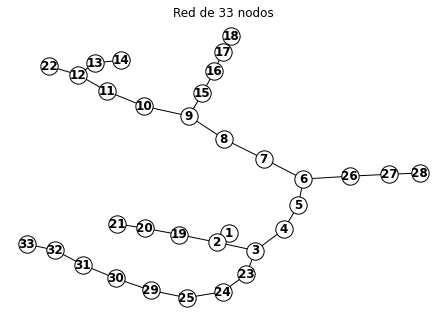

1 - 2, 2 - 3, 3 - 4, 4 - 5, 5 - 6, 6 - 7, 7 - 8, 8 - 9, 9 - 10, 10 - 11, 11 - 12, 12 - 13, 13 - 14, 15 - 16, 16 - 17, 17 - 18, 2 - 19, 19 - 20, 20 - 21, 3 - 23, 23 - 24, 24 - 25, 6 - 26, 26 - 27, 27 - 28, 29 - 30, 30 - 31, 31 - 32, 32 - 33, 9 - 15, 12 - 22, 25 - 29, 


In [211]:

#Si el modelo es óptimo grafica el grafo y la red
#Si no calcula el IIS
if m.status == GRB.OPTIMAL:
    print('Tiempo Corrida: ', m.RunTime)
    # Visulizar el valor de la función objetivo
    print('Costo:', m.objVal*sbase)
    
    red=[]
    estilo=[]
    #Hace lista con arcos que pretenecen a la solución.
    for (i, j) in B:
        print(f"y[{i},{j}]: {y[i, j].X}")
        if y[(i,j)].X>=0.5:
            red.append((i,j))
            estilo.append('solid')
        elif B.index((i,j)) <len(B)/2: 
            estilo.append('dashed')
    
    G1 = nx.Graph()    
    G1.add_nodes_from(N)
    
    G1.add_edges_from(red)
    nx.draw(G1, with_labels=True, node_color="white", font_weight='bold', edgecolors='black')
    plt.title("Red de 33 nodos")
    plt.show()
    
    p=""
    for i,j in red:
        p+=str(i)+" - "+str(j)+ ", "
    print(p)
else:
    m.computeIIS()
    m.write("modelo33.ilp")

# Tunear

In [183]:
m.tune()
for i in range(m.tuneResultCount):
    print(m.getTuneResult(i))
m.optimize()
print(m.RunTime)


Solving model using baseline parameter set with TimeLimit=3600s

Testing candidate parameter set 1...

	MIPGap 1e-07

Solving with random seed #1 ...
Optimize a model with 277 rows, 255 columns and 732 nonzeros
Model fingerprint: 0x3fe63853
Model has 111 quadratic constraints
Variable types: 218 continuous, 37 integer (37 binary)
Coefficient statistics:
  Matrix range     [4e-07, 3e+06]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [6e-04, 1e-02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [1e-02, 3e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 142 rows and 91 columns
Presolve time: 0.00s
Presolved: 135 rows, 164 columns, 490 nonzeros
Presolved model has 37 quadratic constraint(s)
Variable types: 154 continuous, 10 integer (10 binary)

Root relaxation: objective 5.422984e-02, 74 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node 

# Mejoras en el modelo 

1) Se unificaron las variables I y I^2 con lo que se reduce la cantidad de arcos y se logra una mejora en el tiempo computacional 

2) Se elimina la restricción de que los nodos de referencia no generan ya que con el enfoque utilizado no es necesaria. Con el fin de evitar ciclos en la solución final se añade una nueva restricción.

3) Mediante la optimización de parámetros (tuning) en nuestro modelo computacional, hemos alcanzado una notable mejora en el tiempo de ejecución. Pasamos de 0.17 segundos a tan solo 0.049 segundos, marcando una reducción significativa y eficaz en el tiempo computacional. Este logro destaca la eficiencia de ajustar cuidadosamente los parámetros del modelo, permitiéndonos alcanzar resultados óptimos de manera más rápida y efectiva.